# Machine Learning with SAP HANA Cloud

This notebook belongs to the <a href='https://community.sap.com/t5/artificial-intelligence-and-machine-learning-blogs/hands-on-tutorial-machine-learning-with-sap-hana-cloud/ba-p/13683430'>Hands-on Tutorial: Machine Learning with SAP HANA Cloud</a>
## Multiple time-series forecast

### Logon to SAP HANA Cloud

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(address='REPLACEWITHYOURSQLENDPOINT',
                                   port=443,
                                   user='REPLACEWITHYOURDBUSER',
                                   password='REPLACEWITHYOURDBUSERPASSWORD')
conn.connection.isconnected()

True

### Data exploration

Point to the table that contains the data

In [2]:
df_remote = conn.table('OVERNIGHTSTAYS')

Identify the countries with highest number of overnight stays

In [3]:
df_remote.agg([('sum', 'OVERNIGHTSTAYS', 'TOTAL')], group_by='COUNTRYOFRESIDENCE' ).sort('TOTAL', desc=True).head(10).collect()

,COUNTRYOFRESIDENCE,TOTAL
0,Switzerland,50087144
1,Germany,8885041
2,United States,6365130
3,United Kingdom,3726785
4,France,3279915
5,Italy,2027511
6,Netherlands,1676202
7,Belgium,1282186
8,India,1210124
9,Spain,1056512


Obtain that list of countries as comma separated string

In [4]:
countries = df_remote.agg([('sum', 'OVERNIGHTSTAYS', 'TOTAL')], group_by='COUNTRYOFRESIDENCE') \
     .sort('TOTAL', desc=True).select('COUNTRYOFRESIDENCE').head(10).collect() \
     .iloc[:,0].tolist()
countries = str(countries)
countries = countries.replace('[', '(')
countries = countries.replace(']', ')')
countries

"('Switzerland', 'Germany', 'United States', 'United Kingdom', 'France', 'Italy', 'Netherlands', 'Belgium', 'India', 'Spain')"

Use this list of countries to filter the hana_ml DataFrame

In [5]:
df_remote = df_remote.filter(f'''"COUNTRYOFRESIDENCE" IN {countries}''')
df_remote.head(10).collect()

,MONTH,REGION,COUNTRYOFRESIDENCE,OVERNIGHTSTAYS
0,2022-01-01,Graubünden,Switzerland,392805
1,2022-01-01,Graubünden,Germany,80648
2,2022-01-01,Graubünden,France,4229
3,2022-01-01,Graubünden,Italy,10083
4,2022-01-01,Graubünden,United Kingdom,16282
5,2022-01-01,Graubünden,Netherlands,12981
6,2022-01-01,Graubünden,Belgium,6373
7,2022-01-01,Graubünden,Spain,1586
8,2022-01-01,Graubünden,United States,7968
9,2022-01-01,Graubünden,India,162


### Data aggregation
Aggregate the overnight stays by month and country

In [6]:
df_rem_agg = df_remote.agg([('sum', 'OVERNIGHTSTAYS', 'OVERNIGHTSTAYS_SUM')], group_by=['MONTH', 'COUNTRYOFRESIDENCE'])
df_rem_agg = df_rem_agg.sort('MONTH')
df_rem_agg.head(5).collect()

,MONTH,COUNTRYOFRESIDENCE,OVERNIGHTSTAYS_SUM
0,2022-01-01,Italy,43065
1,2022-01-01,Germany,206477
2,2022-01-01,United Kingdom,80724
3,2022-01-01,France,63084
4,2022-01-01,Switzerland,1385583


Prepare the data for plotting the overnights stays over time, by each country

In [7]:
df_data_plot = df_rem_agg.pivot_table(values='OVERNIGHTSTAYS_SUM', index='MONTH', columns='COUNTRYOFRESIDENCE', aggfunc='sum').collect()
df_data_plot

,MONTH,United States,France,Switzerland,Netherlands,Germany,Belgium,Spain,United Kingdom,India,Italy
0,2022-01-01,59643,63084,1385583,51125,206477,26172,15119,80724,4701,43065
1,2022-02-01,66986,114070,1859026,61970,235021,44356,19792,147110,6952,49238
2,2022-03-01,108343,107232,1818422,60176,321906,51150,24435,122879,13151,62094
3,2022-04-01,100853,87271,1505484,35551,259603,30895,27820,87891,17719,62210
4,2022-05-01,197223,101761,1536542,44717,273272,21006,28804,88288,46501,55198
5,2022-06-01,324256,105740,1895620,58417,360223,45554,35781,125924,60179,67727
6,2022-07-01,345639,135677,2337191,112680,414301,110461,46726,141483,50044,71625
7,2022-08-01,296910,181982,2231727,119564,479576,97890,68095,150432,41493,117647
8,2022-09-01,317400,104386,2019546,60502,365616,40571,38586,132657,45605,66293
9,2022-10-01,186930,101124,1875022,39048,261736,17507,31630,79922,41400,69675


Plot the data

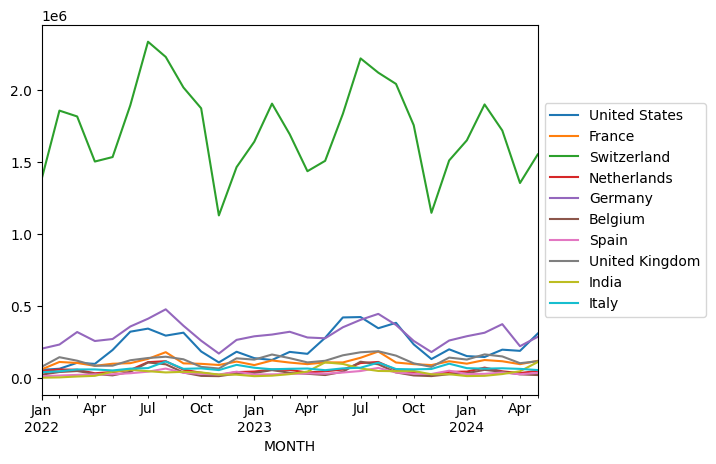

In [8]:
df_data_plot.plot(x='MONTH').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

Focus on Germany and United States only

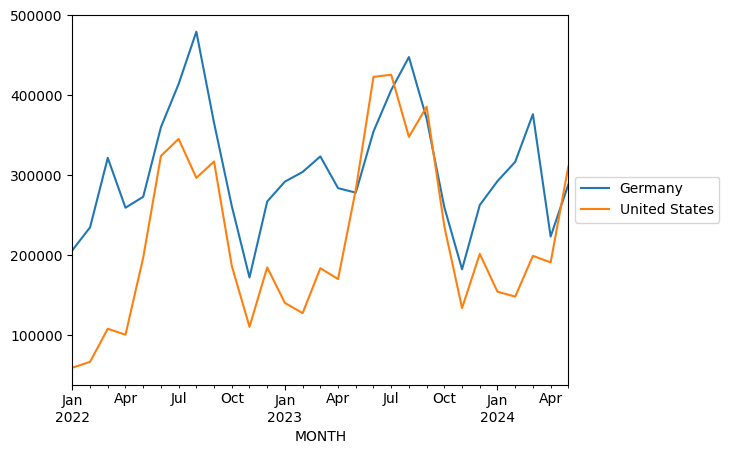

In [9]:
df_data_plot[['MONTH', 'Germany', 'United States']].plot(x='MONTH').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

### Time-series Training - Individually by country
Train individual AdditiveModelForecasts (also known as Prophet) on the monthly aggregates for each country

In [10]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
amf = AdditiveModelForecast(massive=True)
amf.fit(data=df_rem_agg, group_key='COUNTRYOFRESIDENCE')

### Time-series forecast - Individually by country

Create a hana_ml DataFrame that contains the dates/months for which we want to create a forecast.
<BR>Begin by identifying the most recent month from the training history

In [11]:
str_lastdate = df_rem_agg.tail(1, ref_col='MONTH').collect().iloc[0,0]
str_lastdate = str(str_lastdate)[0:10]
print(str_lastdate)

2024-05-01


Create a hana_ml DataFrame that contains the 1st day of the desired months

In [12]:
from hana_ml.algorithms.pal.random import binomial
months_to_forecast=12
df_rem_future = binomial(conn, n=1, p=1, num_random=months_to_forecast)
df_rem_future = df_rem_future.select('*', (f'''ADD_MONTHS(TO_DATE ('{str_lastdate}', 'YYYY-MM-DD'), ID+1)''', 'MONTH') )
df_rem_future = df_rem_future.select('MONTH', ('0', 'TARGET'))
df_rem_future.head(10).collect()

,MONTH,TARGET
0,2024-06-01,0
1,2024-07-01,0
2,2024-08-01,0
3,2024-09-01,0
4,2024-10-01,0
5,2024-11-01,0
6,2024-12-01,0
7,2025-01-01,0
8,2025-02-01,0
9,2025-03-01,0


Create a hana_ml DataFrame that contains the countries for which forecasts should be produced

In [13]:
df_rem_countries = df_remote.agg([('sum', 'OVERNIGHTSTAYS', 'TOTAL'  )], group_by='COUNTRYOFRESIDENCE' ) \
                            .sort('TOTAL', desc=True).select('COUNTRYOFRESIDENCE').head(10)
df_rem_countries.collect()

,COUNTRYOFRESIDENCE
0,Switzerland
1,Germany
2,United States
3,United Kingdom
4,France
5,Italy
6,Netherlands
7,Belgium
8,India
9,Spain


Combine the above two hana_ml Dataframes to create a new DataFrame that contains the future dates/months for each of the country (cartesian product)

In [14]:
df_rem_topredict = conn.sql(df_rem_future.add_id().set_index('ID').join(df_rem_countries.add_id('ID').set_index('ID'), how='cross' ) \
                   .select_statement.replace('ON T0."ID" = T1."ID"', ''))
df_rem_topredict = df_rem_topredict.drop('ID')
df_rem_topredict.head(10).collect()

,MONTH,TARGET,COUNTRYOFRESIDENCE
0,2024-06-01,0,Switzerland
1,2024-06-01,0,Germany
2,2024-06-01,0,United States
3,2024-06-01,0,United Kingdom
4,2024-06-01,0,France
5,2024-06-01,0,Italy
6,2024-06-01,0,Netherlands
7,2024-06-01,0,Belgium
8,2024-06-01,0,India
9,2024-06-01,0,Spain


Apply the trained time-series model to create forecasts for the individual countries for the specified dates

In [15]:
df_rem_pred = amf.predict(data=df_rem_topredict, group_key='COUNTRYOFRESIDENCE')
df_rem_predicted = df_rem_pred[0]

Look deeper into the components of the forecast (ie trend and seasonality)

In [16]:
df_rem_pred[1].collect()

,GROUP_ID,MONTH,TREND,SEASONAL,HOLIDAY,EXOGENOUS
0,Belgium,2024-06-01,46941.400248,"{""seasonalities"":3149.2921693025284}",{},{}
1,Belgium,2024-07-01,46645.400854,"{""seasonalities"":53969.69440653427}",{},{}
2,Belgium,2024-08-01,46339.534814,"{""seasonalities"":47670.95479813893}",{},{}
3,Belgium,2024-09-01,46033.668773,"{""seasonalities"":-10867.900924696365}",{},{}
4,Belgium,2024-10-01,45737.669380,"{""seasonalities"":-35024.82702508839}",{},{}
...,...,...,...,...,...,...
115,United States,2025-01-01,256174.088611,"{""seasonalities"":-105260.40367463966}",{},{}
116,United States,2025-02-01,255710.827254,"{""seasonalities"":-107113.21705733694}",{},{}
117,United States,2025-03-01,255292.397641,"{""seasonalities"":-63771.189585235305}",{},{}
118,United States,2025-04-01,254829.136284,"{""seasonalities"":-74262.95570659888}",{},{}


Verify that there were no error messages

In [17]:
df_rem_pred[2].collect()

,GROUP_ID,ERROR_TIMESTAMP,ERRORCODE,MESSAGE


Look at forecasts for Germany

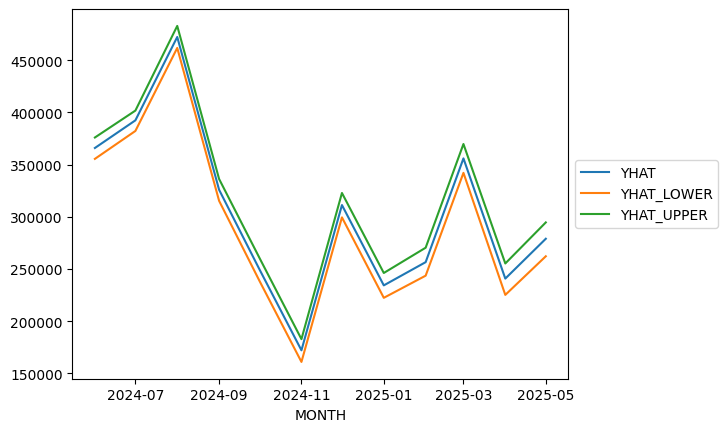

In [18]:
df_data = df_rem_predicted.filter(''' "GROUP_ID" = 'Germany' ''').collect()
df_data.plot(x='MONTH').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

Look at forecats for United States

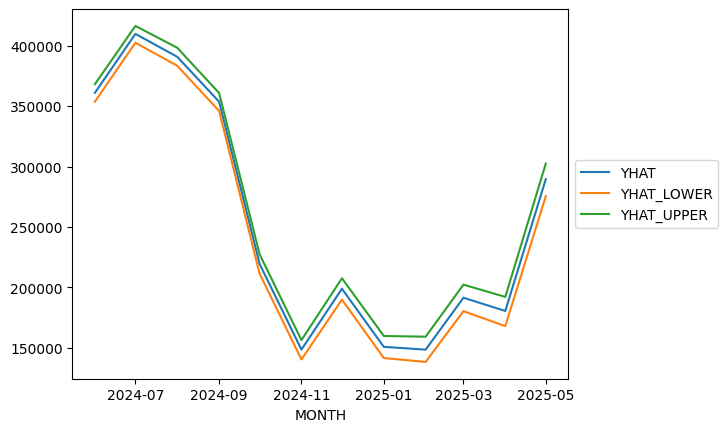

In [19]:
df_data = df_rem_predicted.filter(''' "GROUP_ID" = 'United States' ''').collect()
df_data.plot(x='MONTH').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

Combine the historic and predicted data in a single hana_ml DataFrame

In [20]:
df_rem_predicted = df_rem_predicted.select(
                                  'MONTH',
                                  ('GROUP_ID', 'COUNTRYOFRESIDENCE'),
                                  ('NULL', 'OVERNIGHTSTAYS_SUM'),
                                  ('YHAT', 'FORECAST'),
                                  ('YHAT_LOWER', 'FORECAST_LOWER'),
                                  ('YHAT_UPPER', 'FORECAST_UPPER')
                                 )
df_rem_predicted.head(10).collect()

,MONTH,COUNTRYOFRESIDENCE,OVERNIGHTSTAYS_SUM,FORECAST,FORECAST_LOWER,FORECAST_UPPER
0,2024-06-01,Belgium,None,50090.692417,47179.355840,52902.230886
1,2024-07-01,Belgium,None,100615.095260,97772.913428,103203.242864
2,2024-08-01,Belgium,None,94010.489612,91129.244722,96876.144884
3,2024-09-01,Belgium,None,35165.767849,32295.304795,38081.504865
4,2024-10-01,Belgium,None,10712.842355,7792.915727,13545.383591
5,2024-11-01,Belgium,None,15575.708481,12869.712047,18361.716461
6,2024-12-01,Belgium,None,43761.774900,40908.293027,46512.690767
7,2025-01-01,Belgium,None,22965.284012,20305.027835,25710.642343
8,2025-02-01,Belgium,None,36852.833810,33948.727042,39735.769850
9,2025-03-01,Belgium,None,42565.992528,39522.286258,45665.219362


In [21]:
df_rem_agg = df_rem_agg.select('*', ('NULL', 'FORECAST'),
                                  ('NULL', 'FORECAST_LOWER'),
                                  ('NULL', 'FORECAST_UPPER')
                                  )
df_rem_all = df_rem_predicted.union(df_rem_agg)
df_rem_all.sort('MONTH').tail(20).collect()

,MONTH,COUNTRYOFRESIDENCE,OVERNIGHTSTAYS_SUM,FORECAST,FORECAST_LOWER,FORECAST_UPPER
0,2025-04-01,Italy,None,7.301358e+04,6.667947e+04,7.887995e+04
1,2025-04-01,United States,None,1.805662e+05,1.680320e+05,1.921834e+05
2,2025-04-01,United Kingdom,None,9.974977e+04,9.186934e+04,1.070457e+05
3,2025-04-01,Belgium,None,2.574547e+04,2.259784e+04,2.862533e+04
4,2025-04-01,Switzerland,None,1.378666e+06,1.322983e+06,1.430933e+06
5,2025-04-01,Spain,None,3.213217e+04,2.940963e+04,3.476349e+04
6,2025-04-01,India,None,6.515502e+04,5.293711e+04,7.653153e+04
7,2025-04-01,Germany,None,2.407886e+05,2.251664e+05,2.552813e+05
8,2025-04-01,France,None,1.020115e+05,9.917646e+04,1.046622e+05
9,2025-04-01,Netherlands,None,3.838326e+04,3.441906e+04,4.207428e+04


Save the combined data into a single table in SAP HANA Cloud

In [22]:
df_rem_all.save('OVERNIGHTSTAYS_FORECAST_COUNTRIES', force=True)

Create a plot for a single country

In [23]:
df_data = df_rem_all.filter('''"COUNTRYOFRESIDENCE" = 'Germany' ''').collect()

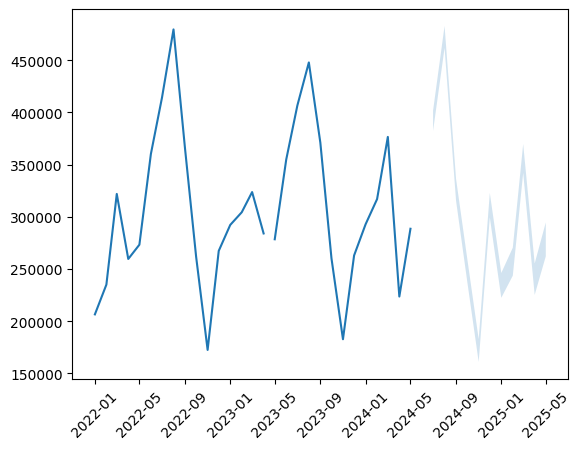

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.fill_between(df_data['MONTH'].values, df_data['FORECAST_LOWER'].values, df_data['FORECAST_UPPER'].values, alpha=0.2)
ax.plot(df_data['MONTH'].values, df_data['OVERNIGHTSTAYS_SUM'].values, '-')
plt.xticks(rotation=45);